In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import LabelEncoder


In [2]:
raw_df = pd.read_csv("accepted_2007_to_2018Q4.csv")
raw_df = raw_df[raw_df['loan_status'] != 'Current']  ## 不分析目前还在贷款期的数据

N = len(raw_df) ## 原生数据的样本量
print("样本量:{}".format(N))

print("关键变量-贷款状态：缺失样本数量{}, 占总样本比例{}".format(np.sum(raw_df['loan_status'].isnull()), \
                                            np.sum(raw_df['loan_status'].isnull()) / N))
print("不满足信贷政策的贷款样本数量{}, 占总样本比例{}".format(len(raw_df[raw_df['loan_status'].str.contains('Does not meet the credit policy',regex = True, na = False)]),\
                                          len(raw_df[raw_df['loan_status'].str.contains('Does not meet the credit policy', regex = True, na = False)]) / N))
raw_df = raw_df[raw_df['loan_status'].notnull()]  ## 删除贷款状态缺失的样本
raw_df = raw_df[~raw_df['loan_status'].str.contains('Does not meet the credit policy')].reset_index(drop = True) ## 删除不满足信贷政策的数据



raw_df['issue_d'] = pd.to_datetime(raw_df['issue_d']) ## 将发放贷款年月数据转成datetime类型数据
raw_df['issue_year'] = raw_df['issue_d'].dt.year  ## 发放贷款年份
raw_df['issue_d'] = raw_df['issue_d'].dt.date  ## 将发放贷款年月数据转成date类型数据
raw_df = raw_df[raw_df['issue_d']>dt.date(2013, 9, 23)]  ## 因为2013年9月23日统计口径发生了改变, 我们只取这个时间点之后的数据

## 去掉缺失值较多的变量, 这些变量对后续分析也并不重要
keep_columns = [column for column in raw_df.columns if np.sum(raw_df[column].isnull()) / N <= 0.1]  ## 只保留缺失值少于10%的变量
raw_df = raw_df[keep_columns] ## 保留缺失值较少的变量

/var/folders/9x/f8fh3wxx5dd2j5tbsxskgj_40000gn/T/ipykernel_1885/2052848582.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv("accepted_2007_to_2018Q4.csv")


样本量:1382384
关键变量-贷款状态：缺失样本数量33, 占总样本比例2.3871804071806386e-05
不满足信贷政策的贷款样本数量2749, 占总样本比例0.0019885936179816896


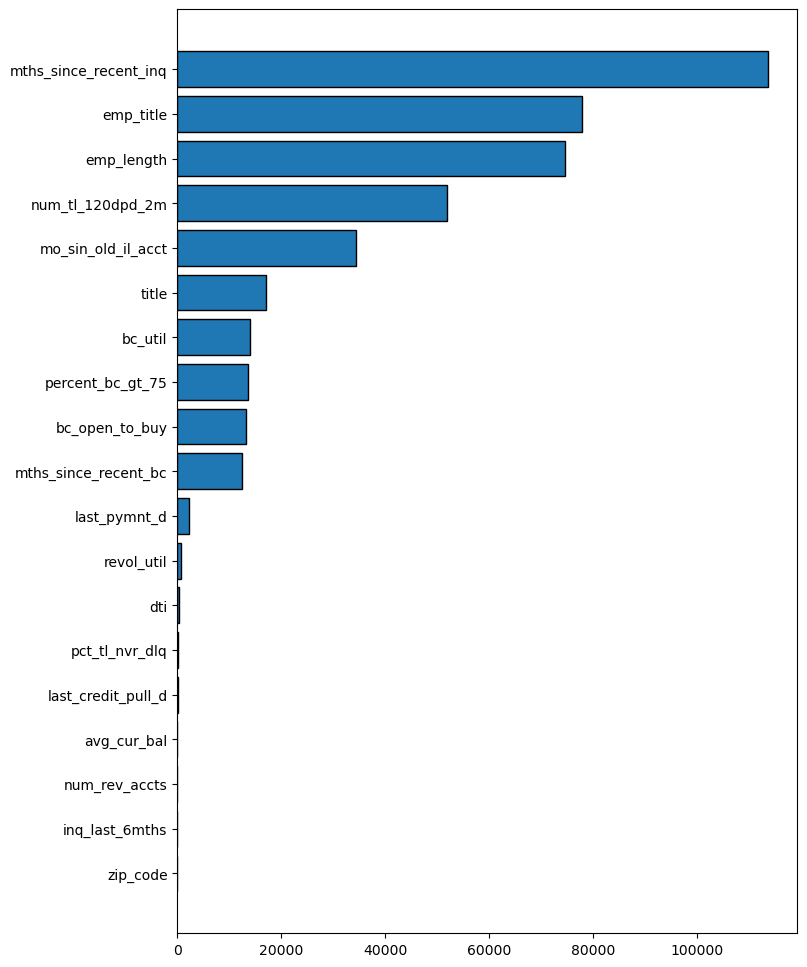

In [3]:
def visualization_nan(data):
    """
    缺失值可视化函数
    Args: 
        data: 数据集
    Returns:
        缺失值可视化柱状图
    """
    ## 存在缺失值的变量和存在缺失值样本量
    include_nan = [(column, np.sum(data[column].isnull())) for column in data.columns if np.sum(data[column].isnull()) > 0]
    include_nan.sort(key = lambda pair : pair[1])  ## 按照缺失值样本量多少排序
    columns = [pair[0] for pair in include_nan]  ## 包含缺失值的变量名
    nums = [pair[1] for pair in include_nan]  ## 缺失值样本量
    plt.figure(figsize = (8, 12))
    plt.barh(y = columns, width = nums, edgecolor = 'black')  ## 绘制柱状图
    plt.show()

visualization_nan(raw_df)
## 删除一些对分析没有用的变量
raw_df.drop(columns = ['mths_since_recent_inq', 'last_credit_pull_d'], inplace = True)
## 一些重要的,采用插补处理存在较大的噪音,缺失值相对较少的变量, 将包含缺失值的样本直接去掉
importance_features = ['bc_util', 'percent_bc_gt_75', 'bc_open_to_buy', 'last_pymnt_d','revol_util', 'dti', 'pct_tl_nvr_dlq',
                       'avg_cur_bal', 'zip_code', 'inq_last_6mths', 'num_rev_accts']
for column in importance_features:
    raw_df = raw_df[raw_df[column].notnull()]


## 一个工作年限的映射字典, 将字符串转化成数字, 便于数据处理
emp_length_dic = {'10+ years' : 10, '3 years' : 3, '4 years' : 4, '6 years' : 6, '7 years' : 7, '8 years': 8, '2 years' : 2, '5 years' : 5,
                  '9 years' : 9, '< 1 year' : 0, '1 year' : 1}
raw_df['emp_length'] = raw_df['emp_length'].map(emp_length_dic) ## 映射
raw_df['emp_length'].replace(np.nan, -1, inplace = True) ## 对于缺失值我们当作一个缺乏信息的样本, 负值为-1, 注意这个变量本身带有定序的意味,因此缺乏信息表明其在信用程度上要弱于其他样本

## 对于一些变量, 适用于填充处理, 用均值填补, 并向下取整
## 在处理的时候, 考虑贷款的发出时间, 仅可以利用贷款发出时间前的数据去做填充, 因此分组的时候考虑贷款发出时间
tmp_df = raw_df[['issue_d', 'num_tl_120dpd_2m', 'mo_sin_old_il_acct', 'emp_length', 'id']].groupby('issue_d').agg({
    'num_tl_120dpd_2m' : np.sum, 'mo_sin_old_il_acct' : np.sum, 'emp_length' : np.sum, 'id': len
}).reset_index()

## 累计求和之后算均值, 即基于贷款发出时间, 过往数据的均值去做填充
tmp_df['id'] = np.cumsum(tmp_df['id'])
for column in tmp_df.columns[1 : -1]:
    tmp_df[column] = (np.cumsum(tmp_df[column]) / tmp_df['id']).apply(lambda x : np.floor(x))

## 根据贷款时间填充数据
for column in ['num_tl_120dpd_2m', 'mo_sin_old_il_acct', 'emp_length']:
    for t in raw_df[raw_df[column].isnull()]['issue_d'].unique():
        indices = (raw_df['issue_d'] == t).index
        raw_df.loc[indices, column] = raw_df.loc[indices, column].fillna(tmp_df[tmp_df['issue_d'] == t][column].values[0])



In [4]:
## 将期限从字符串类型转化成数值
term_dic = {' 36 months' : 0, ' 60 months' : 1}
raw_df['term'] = raw_df['term'].map(term_dic)

def categorical_transform(series):
    """
    Encoder分类变量
    Args:
        series: 序列
    Returns:
        编码后的序列
    """
    lb = LabelEncoder()  ## 设置编码器
    lb.fit(series.unique()) 
    return lb.transform(series), np.sort(series.unique())

## 将一些数量少的类别合并为一类
raw_df['purpose'].replace({'wedding' : 'other', 'educational' : 'other'}, inplace = True)

## 将title的格式转成统一的首字母大写形式
raw_df['title'] = raw_df['title'].apply(lambda x: str(x).capitalize())
raw_df['emp_title'] = raw_df['emp_title'].apply(lambda x: str(x).capitalize())

raw_df.loc[raw_df[raw_df['title'].isin(raw_df['title'].value_counts()[raw_df['title'].value_counts() <= 1000].index)].index, 'title'] = 'Other'
raw_df.loc[raw_df[raw_df['emp_title'].isin(raw_df['emp_title'].value_counts()[raw_df['emp_title'].value_counts() <= 5000].index)].index, 'emp_title'] = 'Other'
## 邮政编码仅披露了前3位
raw_df['zip_code'] = raw_df['zip_code'].apply(lambda x : x[:3])

## 对分类变量进行编码
for column in ['grade', 'sub_grade', 'home_ownership', 'verification_status', 'pymnt_plan',
               'addr_state', 'application_type', 'hardship_flag', 'disbursement_method',
               'purpose', 'title', 'emp_title', 'zip_code']:
    raw_df[column], encoding = categorical_transform(raw_df[column])
    pd.DataFrame({column : encoding, 'encoding' : np.arange(len(encoding))}).to_csv(column + '编码.csv')

## 丢掉一些无助与分析的变量
drop_columns = ['funded_amnt', 'funded_amnt_inv', 'earliest_cr_line', 'initial_list_status', 'out_prncp',
                'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
                'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
                'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code',
                'chargeoff_within_12_mths', 'delinq_amnt',  'num_actv_bc_tl', 'num_bc_sats', 'num_rev_tl_bal_gt_0',
                'num_sats', 'debt_settlement_flag', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
                'mo_sin_rcnt_tl', 'mths_since_recent_bc']

raw_df.drop(columns = drop_columns, inplace = True)


In [5]:
raw_df = raw_df.groupby('loan_status', group_keys = False).apply(lambda x: x.sample(frac = 0.025, random_state = 123))
raw_df.to_csv("商业信贷数据tidy.csv", index = False)